In [1]:
import torch

In [2]:
import pandas as pd

In [3]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [4]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [5]:
import mlflow.pytorch

In [6]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

https://github.com/deepfindr/gnn-project

In [7]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [8]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [9]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [10]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [11]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [12]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [13]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


In [14]:
test_cut_dataset=train_dataset[526:566]
train_cut_dataset= train_dataset[:526]+train_dataset[566:]

In [41]:
from torch_geometric.data import DataLoader

#%% Prepare training
NUM_GRAPHS_PER_BATCH = 10
# NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True,
                         num_workers=0)
# test_loader = DataLoader(test_dataset, 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## MODEL

In [141]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
# torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 256

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # self.linear2 = Linear(1024, 512)
        # self.linear3 = Linear(512, num_classes)  

            # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024 , 512)  
        self.linear3 = Linear(512, 128)  
        self.linear4 = Linear(128, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        # x = self.linear1(x).relu()
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear3(x)


        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear3(x)
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear4(x)

         
        #         # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear2 = Linear(1024 , 512)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear3 = Linear(512, 128)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear4 = Linear(128, num_classes)  

        return x


In [142]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [143]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 2128258


GNN(
  (conv1): GATConv(27, 256, heads=3)
  (head_transform1): Linear(in_features=768, out_features=256, bias=True)
  (pool1): TopKPooling(256, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(256, 256, heads=3)
  (head_transform2): Linear(in_features=768, out_features=256, bias=True)
  (pool2): TopKPooling(256, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(256, 256, heads=3)
  (head_transform3): Linear(in_features=768, out_features=256, bias=True)
  (pool3): TopKPooling(256, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=2, bias=True)
)

In [156]:
#%% Loss and Optimizer
# original loss
weights = torch.tensor([1, 1.2], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# loss in the second gnn
# weight  = torch.tensor([1.3], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)


# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
# optimizer = torch.optim.Adam(model.parameters(),lr=0.0005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.08)


In [157]:
optimizer.zero_grad()        
# loss, hidden = model(data, hidden, targets)
# loss.backward()
clip_value=8
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
optimizer.step()

In [158]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [159]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
#         loss = torch.sqrt(loss_fn(pred, batch.y)) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)
#         print("batch.y")
#         print(batch.y)
        
#         print("pred")
#         print(pred)
        
#         print("loss_v1")
#         print(loss_v1)
#         print("loss_v2")
#         print(loss_v2)
        
        loss=loss_v2
        loss.backward()  
        
        # this is the additional clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=7.0)
        
        
        # Update using the gradients
        optimizer.step()  


        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [160]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(15):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 10 == 0 and epoch !=0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



100%|██████████| 133/133 [00:45<00:00,  2.91it/s]



 Confusion matrix: 
 [[743 403]
 [ 52 123]]
F1 Score: 0.3509272467902996
Accuracy: 0.6555639666919001
Precision: 0.2338403041825095
Recall: 0.7028571428571428
ROC AUC: 0.6755996010969834
Epoch 0 | Train Loss 0.4792582094669342


100%|██████████| 133/133 [00:33<00:00,  3.95it/s]



 Confusion matrix: 
 [[730 342]
 [ 65 184]]
F1 Score: 0.47483870967741937
Accuracy: 0.691900075700227
Precision: 0.34980988593155893
Recall: 0.7389558232931727
ROC AUC: 0.709962986273452
Epoch 1 | Train Loss 0.9715961813926697


100%|██████████| 133/133 [00:53<00:00,  2.48it/s]



 Confusion matrix: 
 [[719 300]
 [ 76 226]]
F1 Score: 0.5458937198067633
Accuracy: 0.7153671461014383
Precision: 0.4296577946768061
Recall: 0.7483443708609272
ROC AUC: 0.7269690450968032
Epoch 2 | Train Loss 0.5177447199821472


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]



 Confusion matrix: 
 [[729 303]
 [ 66 223]]
F1 Score: 0.547239263803681
Accuracy: 0.720666161998486
Precision: 0.42395437262357416
Recall: 0.7716262975778547
ROC AUC: 0.739010823207532
Epoch 3 | Train Loss 0.8986408710479736


100%|██████████| 133/133 [00:42<00:00,  3.12it/s]



 Confusion matrix: 
 [[717 302]
 [ 78 224]]
F1 Score: 0.5410628019323672
Accuracy: 0.712339137017411
Precision: 0.42585551330798477
Recall: 0.7417218543046358
ROC AUC: 0.7226764325497664
Epoch 4 | Train Loss 0.8229638934135437


100%|██████████| 133/133 [00:33<00:00,  3.93it/s]



 Confusion matrix: 
 [[731 320]
 [ 64 206]]
F1 Score: 0.5175879396984925
Accuracy: 0.7093111279333838
Precision: 0.3916349809885932
Recall: 0.762962962962963
ROC AUC: 0.7292455157345739
Epoch 5 | Train Loss 0.8032897114753723


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[728 301]
 [ 67 225]]
F1 Score: 0.550122249388753
Accuracy: 0.7214231642694928
Precision: 0.42775665399239543
Recall: 0.7705479452054794
ROC AUC: 0.7390154692013792
Epoch 6 | Train Loss 0.8292394280433655


100%|██████████| 133/133 [00:33<00:00,  3.97it/s]



 Confusion matrix: 
 [[718 301]
 [ 77 225]]
F1 Score: 0.5434782608695652
Accuracy: 0.7138531415594247
Precision: 0.42775665399239543
Recall: 0.7450331125827815
ROC AUC: 0.7248227388232849
Epoch 7 | Train Loss 0.7253431677818298


100%|██████████| 133/133 [00:34<00:00,  3.82it/s]



 Confusion matrix: 
 [[729 302]
 [ 66 224]]
F1 Score: 0.5490196078431372
Accuracy: 0.7214231642694928
Precision: 0.42585551330798477
Recall: 0.7724137931034483
ROC AUC: 0.7397471487340714
Epoch 8 | Train Loss 1.3459547758102417


100%|██████████| 133/133 [00:33<00:00,  3.91it/s]



 Confusion matrix: 
 [[719 319]
 [ 76 207]]
F1 Score: 0.511742892459827
Accuracy: 0.7009841029523088
Precision: 0.3935361216730038
Recall: 0.7314487632508834
ROC AUC: 0.7120634953055958
Epoch 9 | Train Loss 0.8687307834625244


100%|██████████| 133/133 [00:51<00:00,  2.59it/s]



 Confusion matrix: 
 [[724 317]
 [ 71 209]]
F1 Score: 0.5186104218362283
Accuracy: 0.7062831188493566
Precision: 0.3973384030418251
Recall: 0.7464285714285714
ROC AUC: 0.7209568409496363
Epoch 10 | Train Loss 0.1702430695295334

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 10 | Test Loss 0.8134586215019226


100%|██████████| 133/133 [00:33<00:00,  4.01it/s]



 Confusion matrix: 
 [[727 320]
 [ 68 206]]
F1 Score: 0.515
Accuracy: 0.7062831188493566
Precision: 0.3916349809885932
Recall: 0.7518248175182481
ROC AUC: 0.7230948347381116
Epoch 11 | Train Loss 0.9662371873855591


100%|██████████| 133/133 [00:33<00:00,  3.95it/s]



 Confusion matrix: 
 [[717 316]
 [ 78 210]]
F1 Score: 0.515970515970516
Accuracy: 0.7017411052233157
Precision: 0.39923954372623577
Recall: 0.7291666666666666
ROC AUC: 0.7116307679896741
Epoch 12 | Train Loss 0.8019226789474487


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[716 307]
 [ 79 219]]
F1 Score: 0.5315533980582524
Accuracy: 0.7077971233913701
Precision: 0.41634980988593157
Recall: 0.7348993288590604
ROC AUC: 0.7174007885742029
Epoch 13 | Train Loss 0.8045046925544739


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]


 Confusion matrix: 
 [[722 303]
 [ 73 223]]
F1 Score: 0.5425790754257909
Accuracy: 0.7153671461014383
Precision: 0.42395437262357416
Recall: 0.7533783783783784
ROC AUC: 0.7288843111404087
Epoch 14 | Train Loss 0.8337322473526001
Done.


In [161]:
mlflow.end_run()

In [162]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/24 01:05:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmpgpyxzfkq\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/d00705dd2ca048e384b8e48c1b67db7a/model', model_uuid='33ae701a20bd486395b3642730be505d', run_id='d00705dd2ca048e384b8e48c1b67db7a', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-23 19:35:40.127740', mlflow_version='1.25.1')

Confusion Matrix

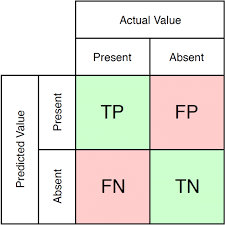

In [163]:
model_type_name="crazy_adam_nightout"

In [164]:
from datetime import date
from datetime import datetime


In [165]:
# SAVE MODEL
#  pls create a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+model_type_name+".pt"
torch.save(model, PATH_to_save_model)

In [166]:
# # Model class must be defined somewhere
# model2 = torch.load(PATH_to_save_model)
# model2.eval()

In [140]:
PATH_to_save_model

'model_saved/model 24_04_2022 00_47_21crazy_adam_acc66.pt'

In [168]:
mlflow.end_run()

In [169]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(150):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 10 == 0 and epoch !=0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



100%|██████████| 133/133 [00:43<00:00,  3.06it/s]



 Confusion matrix: 
 [[726 305]
 [ 69 221]]
F1 Score: 0.5416666666666666
Accuracy: 0.7168811506434519
Precision: 0.42015209125475284
Recall: 0.7620689655172413
ROC AUC: 0.733119836783839
Epoch 0 | Train Loss 0.7432159185409546


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[727 304]
 [ 68 222]]
F1 Score: 0.5441176470588236
Accuracy: 0.7183951551854656
Precision: 0.4220532319391635
Recall: 0.7655172413793103
ROC AUC: 0.7353289407672498
Epoch 1 | Train Loss 0.8459171056747437


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[716 310]
 [ 79 216]]
F1 Score: 0.5261875761266749
Accuracy: 0.7055261165783497
Precision: 0.41064638783269963
Recall: 0.7322033898305085
ROC AUC: 0.715029570158919
Epoch 2 | Train Loss 0.6263079643249512


100%|██████████| 133/133 [00:34<00:00,  3.87it/s]



 Confusion matrix: 
 [[722 298]
 [ 73 228]]
F1 Score: 0.5513905683192261
Accuracy: 0.7191521574564723
Precision: 0.43346007604562736
Recall: 0.7574750830564784
ROC AUC: 0.7326591101556901
Epoch 3 | Train Loss 0.8077403903007507


100%|██████████| 133/133 [00:33<00:00,  4.00it/s]



 Confusion matrix: 
 [[722 319]
 [ 73 207]]
F1 Score: 0.5136476426799008
Accuracy: 0.7032551097653293
Precision: 0.3935361216730038
Recall: 0.7392857142857143
ROC AUC: 0.71642479758474
Epoch 4 | Train Loss 0.8062477707862854


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[726 299]
 [ 69 227]]
F1 Score: 0.5523114355231143
Accuracy: 0.7214231642694928
Precision: 0.43155893536121676
Recall: 0.7668918918918919
ROC AUC: 0.7375922874093604
Epoch 5 | Train Loss 0.8313508629798889


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[721 319]
 [ 74 207]]
F1 Score: 0.5130111524163569
Accuracy: 0.7024981074943225
Precision: 0.3935361216730038
Recall: 0.7366548042704626
ROC AUC: 0.7149620175198467
Epoch 6 | Train Loss 0.7400742173194885


100%|██████████| 133/133 [00:33<00:00,  3.97it/s]



 Confusion matrix: 
 [[729 314]
 [ 66 212]]
F1 Score: 0.5273631840796019
Accuracy: 0.712339137017411
Precision: 0.40304182509505704
Recall: 0.762589928057554
ROC AUC: 0.7307676390048077
Epoch 7 | Train Loss 0.45770731568336487


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[723 308]
 [ 72 218]]
F1 Score: 0.534313725490196
Accuracy: 0.712339137017411
Precision: 0.4144486692015209
Recall: 0.7517241379310344
ROC AUC: 0.7264925248336065
Epoch 8 | Train Loss 0.8925846219062805


100%|██████████| 133/133 [00:33<00:00,  4.00it/s]



 Confusion matrix: 
 [[718 297]
 [ 77 229]]
F1 Score: 0.5504807692307692
Accuracy: 0.7168811506434519
Precision: 0.435361216730038
Recall: 0.7483660130718954
ROC AUC: 0.727877587816736
Epoch 9 | Train Loss 0.8092042207717896


100%|██████████| 133/133 [00:34<00:00,  3.91it/s]



 Confusion matrix: 
 [[718 321]
 [ 77 205]]
F1 Score: 0.5074257425742574
Accuracy: 0.6987130961392884
Precision: 0.3897338403041825
Recall: 0.7269503546099291
ROC AUC: 0.7089997201346084
Epoch 10 | Train Loss 0.806224524974823

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 10 | Test Loss 0.7822290658950806


100%|██████████| 133/133 [00:33<00:00,  3.95it/s]



 Confusion matrix: 
 [[727 310]
 [ 68 216]]
F1 Score: 0.5333333333333333
Accuracy: 0.7138531415594247
Precision: 0.41064638783269963
Recall: 0.7605633802816901
ROC AUC: 0.7308120662257052
Epoch 11 | Train Loss 0.8520069122314453


100%|██████████| 133/133 [00:32<00:00,  4.03it/s]



 Confusion matrix: 
 [[722 312]
 [ 73 214]]
F1 Score: 0.5264452644526445
Accuracy: 0.708554125662377
Precision: 0.4068441064638783
Recall: 0.7456445993031359
ROC AUC: 0.7219518934620128
Epoch 12 | Train Loss 0.865983784198761


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[729 312]
 [ 66 214]]
F1 Score: 0.531017369727047
Accuracy: 0.7138531415594247
Precision: 0.4068441064638783
Recall: 0.7642857142857142
ROC AUC: 0.7322869493618773
Epoch 13 | Train Loss 0.17807264626026154


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]



 Confusion matrix: 
 [[722 305]
 [ 73 221]]
F1 Score: 0.5390243902439025
Accuracy: 0.7138531415594247
Precision: 0.42015209125475284
Recall: 0.7517006802721088
ROC AUC: 0.727359590379482
Epoch 14 | Train Loss 0.9000474810600281


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[714 291]
 [ 81 235]]
F1 Score: 0.5581947743467933
Accuracy: 0.7183951551854656
Precision: 0.4467680608365019
Recall: 0.7436708860759493
ROC AUC: 0.7270593236349896
Epoch 15 | Train Loss 0.5014858245849609


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[727 325]
 [ 68 201]]
F1 Score: 0.5056603773584905
Accuracy: 0.7024981074943225
Precision: 0.3821292775665399
Recall: 0.7472118959107806
ROC AUC: 0.7191382673470254
Epoch 16 | Train Loss 1.0806554555892944


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[724 311]
 [ 71 215]]
F1 Score: 0.5295566502463055
Accuracy: 0.7108251324753975
Precision: 0.40874524714828897
Recall: 0.7517482517482518
ROC AUC: 0.725632579980406
Epoch 17 | Train Loss 0.8190631866455078


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[715 304]
 [ 80 222]]
F1 Score: 0.536231884057971
Accuracy: 0.7093111279333838
Precision: 0.4220532319391635
Recall: 0.7350993377483444
ROC AUC: 0.7183838200027297
Epoch 18 | Train Loss 0.8248125314712524


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[719 302]
 [ 76 224]]
F1 Score: 0.5423728813559322
Accuracy: 0.7138531415594247
Precision: 0.42585551330798477
Recall: 0.7466666666666667
ROC AUC: 0.7254391119817173
Epoch 19 | Train Loss 0.7367161512374878


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[722 304]
 [ 73 222]]
F1 Score: 0.540803897685749
Accuracy: 0.7146101438304315
Precision: 0.4220532319391635
Recall: 0.752542372881356
ROC AUC: 0.7281230382925299
Epoch 20 | Train Loss 0.7742646336555481

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 20 | Test Loss 0.8000290393829346


100%|██████████| 133/133 [00:33<00:00,  3.99it/s]



 Confusion matrix: 
 [[722 293]
 [ 73 233]]
F1 Score: 0.5600961538461539
Accuracy: 0.7229371688115064
Precision: 0.4429657794676806
Recall: 0.761437908496732
ROC AUC: 0.7363839788789078
Epoch 21 | Train Loss 0.6835983395576477


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[725 307]
 [ 70 219]]
F1 Score: 0.5374233128834356
Accuracy: 0.7146101438304315
Precision: 0.41634980988593157
Recall: 0.7577854671280276
ROC AUC: 0.7301524234864943
Epoch 22 | Train Loss 0.8030527234077454


100%|██████████| 133/133 [00:32<00:00,  4.03it/s]



 Confusion matrix: 
 [[729 304]
 [ 66 222]]
F1 Score: 0.5454545454545455
Accuracy: 0.7199091597274792
Precision: 0.4220532319391635
Recall: 0.7708333333333334
ROC AUC: 0.7382724265892224
Epoch 23 | Train Loss 0.9398180246353149


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[723 304]
 [ 72 222]]
F1 Score: 0.5414634146341464
Accuracy: 0.7153671461014383
Precision: 0.4220532319391635
Recall: 0.7551020408163265
ROC AUC: 0.7295471255688254
Epoch 24 | Train Loss 0.49972954392433167


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[722 313]
 [ 73 213]]
F1 Score: 0.5246305418719212
Accuracy: 0.7077971233913701
Precision: 0.4049429657794677
Recall: 0.7447552447552448
ROC AUC: 0.7211698929090233
Epoch 25 | Train Loss 0.8501304388046265


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[720 307]
 [ 75 219]]
F1 Score: 0.5341463414634147
Accuracy: 0.7108251324753975
Precision: 0.41634980988593157
Recall: 0.7448979591836735
ROC AUC: 0.7229845200007948
Epoch 26 | Train Loss 0.8983300924301147


100%|██████████| 133/133 [00:34<00:00,  3.86it/s]



 Confusion matrix: 
 [[726 303]
 [ 69 223]]
F1 Score: 0.5452322738386308
Accuracy: 0.7183951551854656
Precision: 0.42395437262357416
Recall: 0.7636986301369864
ROC AUC: 0.7346189943687848
Epoch 27 | Train Loss 0.5520603060722351


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[720 296]
 [ 75 230]]
F1 Score: 0.5535499398315283
Accuracy: 0.7191521574564723
Precision: 0.4372623574144487
Recall: 0.7540983606557377
ROC AUC: 0.7313798889892862
Epoch 28 | Train Loss 0.4876890778541565


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[719 318]
 [ 76 208]]
F1 Score: 0.5135802469135803
Accuracy: 0.7017411052233157
Precision: 0.39543726235741444
Recall: 0.7323943661971831
ROC AUC: 0.7128702785662868
Epoch 29 | Train Loss 0.8224625587463379


100%|██████████| 133/133 [00:33<00:00,  3.99it/s]



 Confusion matrix: 
 [[725 309]
 [ 70 217]]
F1 Score: 0.5338253382533825
Accuracy: 0.7130961392884179
Precision: 0.41254752851711024
Recall: 0.7560975609756098
ROC AUC: 0.7286290512808417
Epoch 30 | Train Loss 0.7904180884361267

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 30 | Test Loss 0.8008142113685608


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[723 295]
 [ 72 231]]
F1 Score: 0.5572979493365501
Accuracy: 0.7221801665404997
Precision: 0.4391634980988593
Recall: 0.7623762376237624
ROC AUC: 0.7362961738217044
Epoch 31 | Train Loss 0.495766818523407


100%|██████████| 133/133 [00:32<00:00,  4.03it/s]



 Confusion matrix: 
 [[725 314]
 [ 70 212]]
F1 Score: 0.5247524752475247
Accuracy: 0.7093111279333838
Precision: 0.40304182509505704
Recall: 0.75177304964539
ROC AUC: 0.724779691328951
Epoch 32 | Train Loss 0.7893941402435303


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[722 293]
 [ 73 233]]
F1 Score: 0.5600961538461539
Accuracy: 0.7229371688115064
Precision: 0.4429657794676806
Recall: 0.761437908496732
ROC AUC: 0.7363839788789078
Epoch 33 | Train Loss 0.822795569896698


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[726 303]
 [ 69 223]]
F1 Score: 0.5452322738386308
Accuracy: 0.7183951551854656
Precision: 0.42395437262357416
Recall: 0.7636986301369864
ROC AUC: 0.7346189943687848
Epoch 34 | Train Loss 0.47384878993034363


100%|██████████| 133/133 [00:34<00:00,  3.87it/s]



 Confusion matrix: 
 [[727 314]
 [ 68 212]]
F1 Score: 0.5260545905707196
Accuracy: 0.7108251324753975
Precision: 0.40304182509505704
Recall: 0.7571428571428571
ROC AUC: 0.7277549059969809
Epoch 35 | Train Loss 0.8857590556144714


100%|██████████| 133/133 [00:33<00:00,  4.03it/s]



 Confusion matrix: 
 [[719 303]
 [ 76 223]]
F1 Score: 0.5406060606060606
Accuracy: 0.7130961392884179
Precision: 0.42395437262357416
Recall: 0.745819397993311
ROC AUC: 0.7246709514428394
Epoch 36 | Train Loss 0.6868487596511841


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[715 309]
 [ 80 217]]
F1 Score: 0.5273390036452005
Accuracy: 0.7055261165783497
Precision: 0.41254752851711024
Recall: 0.7306397306397306
ROC AUC: 0.7144409590698653
Epoch 37 | Train Loss 0.892385721206665


100%|██████████| 133/133 [00:32<00:00,  4.04it/s]



 Confusion matrix: 
 [[725 300]
 [ 70 226]]
F1 Score: 0.5498783454987836
Accuracy: 0.7199091597274792
Precision: 0.4296577946768061
Recall: 0.7635135135135135
ROC AUC: 0.7354152933421226
Epoch 38 | Train Loss 0.8859350085258484


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[726 318]
 [ 69 208]]
F1 Score: 0.5180572851805728
Accuracy: 0.7070401211203634
Precision: 0.39543726235741444
Recall: 0.7509025270758123
ROC AUC: 0.7231524129631934
Epoch 39 | Train Loss 0.8136139512062073


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[726 305]
 [ 69 221]]
F1 Score: 0.5416666666666666
Accuracy: 0.7168811506434519
Precision: 0.42015209125475284
Recall: 0.7620689655172413
ROC AUC: 0.733119836783839
Epoch 40 | Train Loss 0.5324301719665527

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 40 | Test Loss 0.8024901747703552


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[726 305]
 [ 69 221]]
F1 Score: 0.5416666666666666
Accuracy: 0.7168811506434519
Precision: 0.42015209125475284
Recall: 0.7620689655172413
ROC AUC: 0.733119836783839
Epoch 41 | Train Loss 0.7644392251968384


100%|██████████| 133/133 [00:32<00:00,  4.04it/s]



 Confusion matrix: 
 [[726 302]
 [ 69 224]]
F1 Score: 0.547008547008547
Accuracy: 0.7191521574564723
Precision: 0.42585551330798477
Recall: 0.764505119453925
ROC AUC: 0.7353654001938885
Epoch 42 | Train Loss 0.5136245489120483


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[719 309]
 [ 76 217]]
F1 Score: 0.5299145299145299
Accuracy: 0.708554125662377
Precision: 0.41254752851711024
Recall: 0.7406143344709898
ROC AUC: 0.7200153384417206
Epoch 43 | Train Loss 0.6909330487251282


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[719 314]
 [ 76 212]]
F1 Score: 0.5208845208845209
Accuracy: 0.7047691143073429
Precision: 0.40304182509505704
Recall: 0.7361111111111112
ROC AUC: 0.7160710444229321
Epoch 44 | Train Loss 0.7899301052093506


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[722 293]
 [ 73 233]]
F1 Score: 0.5600961538461539
Accuracy: 0.7229371688115064
Precision: 0.4429657794676806
Recall: 0.761437908496732
ROC AUC: 0.7363839788789078
Epoch 45 | Train Loss 0.8334877490997314


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[723 322]
 [ 72 204]]
F1 Score: 0.5087281795511222
Accuracy: 0.7017411052233157
Precision: 0.38783269961977185
Recall: 0.7391304347826086
ROC AUC: 0.7154982317453713
Epoch 46 | Train Loss 0.5115034580230713


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[719 313]
 [ 76 213]]
F1 Score: 0.5226993865030675
Accuracy: 0.7055261165783497
Precision: 0.4049429657794677
Recall: 0.7370242214532872
ROC AUC: 0.7168648239049381
Epoch 47 | Train Loss 0.8599578142166138


100%|██████████| 133/133 [00:33<00:00,  4.01it/s]



 Confusion matrix: 
 [[723 294]
 [ 72 232]]
F1 Score: 0.5590361445783132
Accuracy: 0.7229371688115064
Precision: 0.44106463878326996
Recall: 0.7631578947368421
ROC AUC: 0.737036174507064
Epoch 48 | Train Loss 0.8519649505615234


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[729 292]
 [ 66 234]]
F1 Score: 0.5665859564164649
Accuracy: 0.728993186979561
Precision: 0.4448669201520912
Recall: 0.78
ROC AUC: 0.7470029382957885
Epoch 49 | Train Loss 0.8106015920639038


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[720 306]
 [ 75 220]]
F1 Score: 0.535931790499391
Accuracy: 0.7115821347464042
Precision: 0.41825095057034223
Recall: 0.7457627118644068
ROC AUC: 0.7237585489146595
Epoch 50 | Train Loss 0.4682401120662689

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 50 | Test Loss 0.717700183391571


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[718 313]
 [ 77 213]]
F1 Score: 0.5220588235294118
Accuracy: 0.7047691143073429
Precision: 0.4049429657794677
Recall: 0.7344827586206897
ROC AUC: 0.7154470049165524
Epoch 51 | Train Loss 0.4795877933502197


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[725 300]
 [ 70 226]]
F1 Score: 0.5498783454987836
Accuracy: 0.7199091597274792
Precision: 0.4296577946768061
Recall: 0.7635135135135135
ROC AUC: 0.7354152933421226
Epoch 52 | Train Loss 0.8537243604660034


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[717 304]
 [ 78 222]]
F1 Score: 0.5375302663438256
Accuracy: 0.7108251324753975
Precision: 0.4220532319391635
Recall: 0.74
ROC AUC: 0.7211263467189031
Epoch 53 | Train Loss 0.8289493918418884


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[720 300]
 [ 75 226]]
F1 Score: 0.5465538089480049
Accuracy: 0.7161241483724451
Precision: 0.4296577946768061
Recall: 0.7508305647840532
ROC AUC: 0.7283564588626148
Epoch 54 | Train Loss 0.8050892949104309


100%|██████████| 133/133 [00:33<00:00,  4.01it/s]



 Confusion matrix: 
 [[716 314]
 [ 79 212]]
F1 Score: 0.5189718482252141
Accuracy: 0.7024981074943225
Precision: 0.40304182509505704
Recall: 0.7285223367697594
ROC AUC: 0.7118339839188603
Epoch 55 | Train Loss 0.8140613436698914


100%|██████████| 133/133 [00:32<00:00,  4.04it/s]



 Confusion matrix: 
 [[728 309]
 [ 67 217]]
F1 Score: 0.5358024691358024
Accuracy: 0.7153671461014383
Precision: 0.41254752851711024
Recall: 0.7640845070422535
ROC AUC: 0.7330547896831325
Epoch 56 | Train Loss 0.8309435844421387


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[723 315]
 [ 72 211]]
F1 Score: 0.5216316440049443
Accuracy: 0.7070401211203634
Precision: 0.4011406844106464
Recall: 0.7455830388692579
ROC AUC: 0.7210574153883862
Epoch 57 | Train Loss 0.47104281187057495


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[725 312]
 [ 70 214]]
F1 Score: 0.5283950617283951
Accuracy: 0.7108251324753975
Precision: 0.4068441064638783
Recall: 0.7535211267605634
ROC AUC: 0.7263266193108506
Epoch 58 | Train Loss 0.8995469808578491


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[731 303]
 [ 64 223]]
F1 Score: 0.5485854858548587
Accuracy: 0.7221801665404997
Precision: 0.42395437262357416
Recall: 0.7770034843205574
ROC AUC: 0.7419833669184994
Epoch 59 | Train Loss 0.8338521718978882


100%|██████████| 133/133 [00:33<00:00,  4.01it/s]



 Confusion matrix: 
 [[715 298]
 [ 80 228]]
F1 Score: 0.5467625899280576
Accuracy: 0.7138531415594247
Precision: 0.43346007604562736
Recall: 0.7402597402597403
ROC AUC: 0.7230420122818938
Epoch 60 | Train Loss 0.8454387784004211

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 60 | Test Loss 0.7819604873657227


100%|██████████| 133/133 [00:33<00:00,  3.99it/s]



 Confusion matrix: 
 [[725 295]
 [ 70 231]]
F1 Score: 0.5586457073760581
Accuracy: 0.7236941710825132
Precision: 0.4391634980988593
Recall: 0.7674418604651163
ROC AUC: 0.7391130870953031
Epoch 61 | Train Loss 0.9814038276672363


100%|██████████| 133/133 [00:32<00:00,  4.04it/s]



 Confusion matrix: 
 [[717 306]
 [ 78 220]]
F1 Score: 0.5339805825242719
Accuracy: 0.7093111279333838
Precision: 0.41825095057034223
Recall: 0.738255033557047
ROC AUC: 0.7195673994764707
Epoch 62 | Train Loss 0.8028463125228882


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[726 325]
 [ 69 201]]
F1 Score: 0.5050251256281407
Accuracy: 0.7017411052233157
Precision: 0.3821292775665399
Recall: 0.7444444444444445
ROC AUC: 0.7176075695105191
Epoch 63 | Train Loss 0.4888348877429962


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[723 288]
 [ 72 238]]
F1 Score: 0.5693779904306219
Accuracy: 0.7274791824375473
Precision: 0.4524714828897338
Recall: 0.7677419354838709
ROC AUC: 0.7414377333205704
Epoch 64 | Train Loss 0.8855272531509399


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[713 297]
 [ 82 229]]
F1 Score: 0.5471923536439666
Accuracy: 0.7130961392884179
Precision: 0.435361216730038
Recall: 0.7363344051446945
ROC AUC: 0.7211374996020502
Epoch 65 | Train Loss 0.8072863221168518


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[722 301]
 [ 73 225]]
F1 Score: 0.5461165048543689
Accuracy: 0.7168811506434519
Precision: 0.42775665399239543
Recall: 0.7550335570469798
ROC AUC: 0.7304004539878105
Epoch 66 | Train Loss 0.8334918022155762


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[719 326]
 [ 76 200]]
F1 Score: 0.4987531172069825
Accuracy: 0.6956850870552612
Precision: 0.38022813688212925
Recall: 0.7246376811594203
ROC AUC: 0.7063379793356911
Epoch 67 | Train Loss 0.6383963227272034


100%|██████████| 133/133 [00:32<00:00,  4.04it/s]



 Confusion matrix: 
 [[719 306]
 [ 76 220]]
F1 Score: 0.5352798053527981
Accuracy: 0.7108251324753975
Precision: 0.41825095057034223
Recall: 0.7432432432432432
ROC AUC: 0.7223533289386947
Epoch 68 | Train Loss 0.9293434619903564


100%|██████████| 133/133 [00:33<00:00,  3.97it/s]



 Confusion matrix: 
 [[714 302]
 [ 81 224]]
F1 Score: 0.539109506618532
Accuracy: 0.7100681302043906
Precision: 0.42585551330798477
Recall: 0.7344262295081967
ROC AUC: 0.7185910675100038
Epoch 69 | Train Loss 0.5607461333274841


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[720 312]
 [ 75 214]]
F1 Score: 0.5251533742331288
Accuracy: 0.7070401211203634
Precision: 0.4068441064638783
Recall: 0.740484429065744
ROC AUC: 0.7190794238351976
Epoch 70 | Train Loss 0.5577988624572754

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 70 | Test Loss 0.8183926343917847


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[726 306]
 [ 69 220]]
F1 Score: 0.539877300613497
Accuracy: 0.7161241483724451
Precision: 0.41825095057034223
Recall: 0.7612456747404844
ROC AUC: 0.7323670234167537
Epoch 71 | Train Loss 0.8988049626350403


100%|██████████| 133/133 [00:33<00:00,  3.98it/s]



 Confusion matrix: 
 [[724 318]
 [ 71 208]]
F1 Score: 0.5167701863354037
Accuracy: 0.7055261165783497
Precision: 0.39543726235741444
Recall: 0.7455197132616488
ROC AUC: 0.7201686858054884
Epoch 72 | Train Loss 0.48482146859169006


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[723 295]
 [ 72 231]]
F1 Score: 0.5572979493365501
Accuracy: 0.7221801665404997
Precision: 0.4391634980988593
Recall: 0.7623762376237624
ROC AUC: 0.7362961738217044
Epoch 73 | Train Loss 0.8988816738128662


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[713 296]
 [ 82 230]]
F1 Score: 0.548926014319809
Accuracy: 0.7138531415594247
Precision: 0.4372623574144487
Recall: 0.7371794871794872
ROC AUC: 0.7219098625193769
Epoch 74 | Train Loss 0.5073170065879822


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[722 311]
 [ 73 215]]
F1 Score: 0.5282555282555282
Accuracy: 0.7093111279333838
Precision: 0.40874524714828897
Recall: 0.7465277777777778
ROC AUC: 0.7227314590728191
Epoch 75 | Train Loss 0.8392993211746216


100%|██████████| 133/133 [00:33<00:00,  3.99it/s]



 Confusion matrix: 
 [[732 321]
 [ 63 205]]
F1 Score: 0.5163727959697733
Accuracy: 0.7093111279333838
Precision: 0.3897338403041825
Recall: 0.7649253731343284
ROC AUC: 0.7300410341455119
Epoch 76 | Train Loss 0.8022089600563049


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]



 Confusion matrix: 
 [[723 306]
 [ 72 220]]
F1 Score: 0.5378973105134474
Accuracy: 0.7138531415594247
Precision: 0.41825095057034223
Recall: 0.7534246575342466
ROC AUC: 0.7280242821198929
Epoch 77 | Train Loss 0.7832425832748413


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[718 308]
 [ 77 218]]
F1 Score: 0.5310596833130329
Accuracy: 0.708554125662377
Precision: 0.4144486692015209
Recall: 0.7389830508474576
ROC AUC: 0.7193940595367891
Epoch 78 | Train Loss 0.8301880955696106


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[720 311]
 [ 75 215]]
F1 Score: 0.5269607843137256
Accuracy: 0.7077971233913701
Precision: 0.40874524714828897
Recall: 0.7413793103448276
ROC AUC: 0.719865212883374
Epoch 79 | Train Loss 0.8228445053100586


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[722 304]
 [ 73 222]]
F1 Score: 0.540803897685749
Accuracy: 0.7146101438304315
Precision: 0.4220532319391635
Recall: 0.752542372881356
ROC AUC: 0.7281230382925299
Epoch 80 | Train Loss 0.8319646120071411

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 80 | Test Loss 0.7716106176376343


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[719 304]
 [ 76 222]]
F1 Score: 0.5388349514563107
Accuracy: 0.712339137017411
Precision: 0.4220532319391635
Recall: 0.7449664429530202
ROC AUC: 0.7239006212810067
Epoch 81 | Train Loss 0.6830018162727356


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[717 322]
 [ 78 204]]
F1 Score: 0.504950495049505
Accuracy: 0.6971990915972748
Precision: 0.38783269961977185
Recall: 0.723404255319149
ROC AUC: 0.7067454385354167
Epoch 82 | Train Loss 0.8482560515403748


100%|██████████| 133/133 [00:33<00:00,  4.02it/s]



 Confusion matrix: 
 [[727 300]
 [ 68 226]]
F1 Score: 0.5512195121951219
Accuracy: 0.7214231642694928
Precision: 0.4296577946768061
Recall: 0.7687074829931972
ROC AUC: 0.7382972663261994
Epoch 83 | Train Loss 0.8378594517707825


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[723 312]
 [ 72 214]]
F1 Score: 0.5270935960591133
Accuracy: 0.7093111279333838
Precision: 0.4068441064638783
Recall: 0.7482517482517482
ROC AUC: 0.7234012364447148
Epoch 84 | Train Loss 0.7378813624382019


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[722 314]
 [ 73 212]]
F1 Score: 0.5228113440197287
Accuracy: 0.7070401211203634
Precision: 0.40304182509505704
Recall: 0.743859649122807
ROC AUC: 0.7203854230170021
Epoch 85 | Train Loss 0.4779069721698761


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[713 301]
 [ 82 225]]
F1 Score: 0.5402160864345739
Accuracy: 0.7100681302043906
Precision: 0.42775665399239543
Recall: 0.7328990228013029
ROC AUC: 0.7180274206708683
Epoch 86 | Train Loss 0.8081520199775696


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[721 309]
 [ 74 217]]
F1 Score: 0.5312117503059975
Accuracy: 0.7100681302043906
Precision: 0.41254752851711024
Recall: 0.7457044673539519
ROC AUC: 0.7228522336769759
Epoch 87 | Train Loss 0.4999706745147705


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[721 308]
 [ 74 218]]
F1 Score: 0.5330073349633252
Accuracy: 0.7108251324753975
Precision: 0.4144486692015209
Recall: 0.7465753424657534
ROC AUC: 0.7236278072872986
Epoch 88 | Train Loss 0.8680412769317627


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[724 311]
 [ 71 215]]
F1 Score: 0.5295566502463055
Accuracy: 0.7108251324753975
Precision: 0.40874524714828897
Recall: 0.7517482517482518
ROC AUC: 0.725632579980406
Epoch 89 | Train Loss 0.48202016949653625


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[717 314]
 [ 78 212]]
F1 Score: 0.5196078431372548
Accuracy: 0.7032551097653293
Precision: 0.40304182509505704
Recall: 0.7310344827586207
ROC AUC: 0.7132379009331417
Epoch 90 | Train Loss 0.4565883278846741

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 90 | Test Loss 0.8192201256752014


100%|██████████| 133/133 [00:32<00:00,  4.09it/s]



 Confusion matrix: 
 [[728 301]
 [ 67 225]]
F1 Score: 0.550122249388753
Accuracy: 0.7214231642694928
Precision: 0.42775665399239543
Recall: 0.7705479452054794
ROC AUC: 0.7390154692013792
Epoch 91 | Train Loss 0.808768630027771


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[717 296]
 [ 78 230]]
F1 Score: 0.5515587529976019
Accuracy: 0.7168811506434519
Precision: 0.4372623574144487
Recall: 0.7467532467532467
ROC AUC: 0.7272759323598416
Epoch 92 | Train Loss 0.8748428821563721


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[727 299]
 [ 68 227]]
F1 Score: 0.5529841656516443
Accuracy: 0.7221801665404997
Precision: 0.43155893536121676
Recall: 0.7694915254237288
ROC AUC: 0.7390342617372054
Epoch 93 | Train Loss 0.8213537931442261


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[729 300]
 [ 66 226]]
F1 Score: 0.5525672371638142
Accuracy: 0.7229371688115064
Precision: 0.4296577946768061
Recall: 0.773972602739726
ROC AUC: 0.7412137066176763
Epoch 94 | Train Loss 0.8440641164779663


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[716 322]
 [ 79 204]]
F1 Score: 0.5043263288009888
Accuracy: 0.6964420893262679
Precision: 0.38783269961977185
Recall: 0.7208480565371025
ROC AUC: 0.7053180552435031
Epoch 95 | Train Loss 0.5695753693580627


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[723 303]
 [ 72 223]]
F1 Score: 0.5432399512789281
Accuracy: 0.7161241483724451
Precision: 0.42395437262357416
Recall: 0.7559322033898305
ROC AUC: 0.730305282981465
Epoch 96 | Train Loss 0.47457611560821533


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[725 312]
 [ 70 214]]
F1 Score: 0.5283950617283951
Accuracy: 0.7108251324753975
Precision: 0.4068441064638783
Recall: 0.7535211267605634
ROC AUC: 0.7263266193108506
Epoch 97 | Train Loss 0.7438920140266418


100%|██████████| 133/133 [00:32<00:00,  4.15it/s]



 Confusion matrix: 
 [[720 311]
 [ 75 215]]
F1 Score: 0.5269607843137256
Accuracy: 0.7077971233913701
Precision: 0.40874524714828897
Recall: 0.7413793103448276
ROC AUC: 0.719865212883374
Epoch 98 | Train Loss 0.5476793646812439


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[725 315]
 [ 70 211]]
F1 Score: 0.5229244114002479
Accuracy: 0.708554125662377
Precision: 0.4011406844106464
Recall: 0.7508896797153025
ROC AUC: 0.7240025321653436
Epoch 99 | Train Loss 0.9733268022537231


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[726 299]
 [ 69 227]]
F1 Score: 0.5523114355231143
Accuracy: 0.7214231642694928
Precision: 0.43155893536121676
Recall: 0.7668918918918919
ROC AUC: 0.7375922874093604
Epoch 100 | Train Loss 0.805512547492981

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 100 | Test Loss 0.7372785806655884


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[715 299]
 [ 80 227]]
F1 Score: 0.5450180072028812
Accuracy: 0.7130961392884179
Precision: 0.43155893536121676
Recall: 0.739413680781759
ROC AUC: 0.722270942954982
Epoch 101 | Train Loss 0.8611840009689331


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[726 303]
 [ 69 223]]
F1 Score: 0.5452322738386308
Accuracy: 0.7183951551854656
Precision: 0.42395437262357416
Recall: 0.7636986301369864
ROC AUC: 0.7346189943687848
Epoch 102 | Train Loss 0.8268391489982605


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[723 300]
 [ 72 226]]
F1 Score: 0.5485436893203883
Accuracy: 0.7183951551854656
Precision: 0.4296577946768061
Recall: 0.7583892617449665
ROC AUC: 0.7325670648900785
Epoch 103 | Train Loss 0.4662865996360779


100%|██████████| 133/133 [00:32<00:00,  4.06it/s]



 Confusion matrix: 
 [[722 302]
 [ 73 224]]
F1 Score: 0.5443499392466585
Accuracy: 0.7161241483724451
Precision: 0.42585551330798477
Recall: 0.7542087542087542
ROC AUC: 0.7296434396043772
Epoch 104 | Train Loss 0.7500604391098022


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[728 302]
 [ 67 224]]
F1 Score: 0.5483476132190942
Accuracy: 0.720666161998486
Precision: 0.42585551330798477
Recall: 0.7697594501718213
ROC AUC: 0.7382777833383378
Epoch 105 | Train Loss 0.8369458317756653


100%|██████████| 133/133 [00:31<00:00,  4.19it/s]



 Confusion matrix: 
 [[713 310]
 [ 82 216]]
F1 Score: 0.5242718446601942
Accuracy: 0.7032551097653293
Precision: 0.41064638783269963
Recall: 0.7248322147651006
ROC AUC: 0.7109009558673989
Epoch 106 | Train Loss 0.9433718919754028


100%|██████████| 133/133 [00:32<00:00,  4.11it/s]



 Confusion matrix: 
 [[719 298]
 [ 76 228]]
F1 Score: 0.5493975903614459
Accuracy: 0.7168811506434519
Precision: 0.43346007604562736
Recall: 0.75
ROC AUC: 0.7284906588003933
Epoch 107 | Train Loss 0.4798389971256256


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[714 300]
 [ 81 226]]
F1 Score: 0.5426170468187275
Accuracy: 0.7115821347464042
Precision: 0.4296577946768061
Recall: 0.7361563517915309
ROC AUC: 0.7201491818129252
Epoch 108 | Train Loss 0.6043810844421387


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[726 311]
 [ 69 215]]
F1 Score: 0.5308641975308642
Accuracy: 0.712339137017411
Precision: 0.40874524714828897
Recall: 0.7570422535211268
ROC AUC: 0.728569342768278
Epoch 109 | Train Loss 0.8091496825218201


100%|██████████| 133/133 [00:31<00:00,  4.24it/s]



 Confusion matrix: 
 [[716 292]
 [ 79 234]]
F1 Score: 0.5578069129916566
Accuracy: 0.7191521574564723
Precision: 0.4448669201520912
Recall: 0.7476038338658147
ROC AUC: 0.7289606470916375
Epoch 110 | Train Loss 0.8356299996376038

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 110 | Test Loss 0.7746708393096924


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[724 307]
 [ 71 219]]
F1 Score: 0.5367647058823529
Accuracy: 0.7138531415594247
Precision: 0.41634980988593157
Recall: 0.7551724137931034
ROC AUC: 0.7287016288170173
Epoch 111 | Train Loss 0.8091667890548706


100%|██████████| 133/133 [00:31<00:00,  4.19it/s]



 Confusion matrix: 
 [[724 301]
 [ 71 225]]
F1 Score: 0.5474452554744526
Accuracy: 0.7183951551854656
Precision: 0.42775665399239543
Recall: 0.7601351351351351
ROC AUC: 0.7332382992748845
Epoch 112 | Train Loss 0.44059330224990845


100%|██████████| 133/133 [00:31<00:00,  4.19it/s]



 Confusion matrix: 
 [[727 311]
 [ 68 215]]
F1 Score: 0.5315203955500618
Accuracy: 0.7130961392884179
Precision: 0.40874524714828897
Recall: 0.7597173144876325
ROC AUC: 0.7300513354711766
Epoch 113 | Train Loss 0.9348196387290955


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]



 Confusion matrix: 
 [[720 309]
 [ 75 217]]
F1 Score: 0.530562347188264
Accuracy: 0.7093111279333838
Precision: 0.41254752851711024
Recall: 0.7431506849315068
ROC AUC: 0.7214295698710013
Epoch 114 | Train Loss 0.4506966769695282


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[718 322]
 [ 77 204]]
F1 Score: 0.5055762081784386
Accuracy: 0.6979560938682816
Precision: 0.38783269961977185
Recall: 0.7259786476868327
ROC AUC: 0.708181631535724
Epoch 115 | Train Loss 0.49227356910705566


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[723 321]
 [ 72 205]]
F1 Score: 0.510585305105853
Accuracy: 0.7024981074943225
Precision: 0.3897338403041825
Recall: 0.740072202166065
ROC AUC: 0.7163004688991244
Epoch 116 | Train Loss 0.8123580813407898


100%|██████████| 133/133 [00:32<00:00,  4.15it/s]



 Confusion matrix: 
 [[717 307]
 [ 78 219]]
F1 Score: 0.5321992709599027
Accuracy: 0.708554125662377
Precision: 0.41634980988593157
Recall: 0.7373737373737373
ROC AUC: 0.7187845249368687
Epoch 117 | Train Loss 0.832754909992218


100%|██████████| 133/133 [00:32<00:00,  4.03it/s]



 Confusion matrix: 
 [[727 296]
 [ 68 230]]
F1 Score: 0.5582524271844661
Accuracy: 0.72445117335352
Precision: 0.4372623574144487
Recall: 0.7718120805369127
ROC AUC: 0.7412335084991505
Epoch 118 | Train Loss 0.815445065498352


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[723 309]
 [ 72 217]]
F1 Score: 0.5325153374233129
Accuracy: 0.7115821347464042
Precision: 0.41254752851711024
Recall: 0.7508650519031141
ROC AUC: 0.7257232236259756
Epoch 119 | Train Loss 0.8452546000480652


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[723 310]
 [ 72 216]]
F1 Score: 0.5307125307125308
Accuracy: 0.7108251324753975
Precision: 0.41064638783269963
Recall: 0.75
ROC AUC: 0.7249515972894484
Epoch 120 | Train Loss 0.35559436678886414

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 120 | Test Loss 0.7384364604949951


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[727 327]
 [ 68 199]]
F1 Score: 0.501891551071879
Accuracy: 0.7009841029523088
Precision: 0.37832699619771865
Recall: 0.7453183520599251
ROC AUC: 0.7175358363715185
Epoch 121 | Train Loss 0.8363837003707886


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[724 298]
 [ 71 228]]
F1 Score: 0.5527272727272726
Accuracy: 0.720666161998486
Precision: 0.43346007604562736
Recall: 0.7625418060200669
ROC AUC: 0.7354783394092507
Epoch 122 | Train Loss 0.8255558013916016


100%|██████████| 133/133 [00:31<00:00,  4.19it/s]



 Confusion matrix: 
 [[723 303]
 [ 72 223]]
F1 Score: 0.5432399512789281
Accuracy: 0.7161241483724451
Precision: 0.42395437262357416
Recall: 0.7559322033898305
ROC AUC: 0.730305282981465
Epoch 123 | Train Loss 0.7698720097541809


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[729 288]
 [ 66 238]]
F1 Score: 0.5734939759036145
Accuracy: 0.7320211960635882
Precision: 0.4524714828897338
Recall: 0.7828947368421053
ROC AUC: 0.7498544480670704
Epoch 124 | Train Loss 0.5128604173660278


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[719 318]
 [ 76 208]]
F1 Score: 0.5135802469135803
Accuracy: 0.7017411052233157
Precision: 0.39543726235741444
Recall: 0.7323943661971831
ROC AUC: 0.7128702785662868
Epoch 125 | Train Loss 0.8164243698120117


100%|██████████| 133/133 [00:32<00:00,  4.16it/s]



 Confusion matrix: 
 [[722 307]
 [ 73 219]]
F1 Score: 0.5354523227383864
Accuracy: 0.712339137017411
Precision: 0.41634980988593157
Recall: 0.75
ROC AUC: 0.7258260447035957
Epoch 126 | Train Loss 0.854351282119751


100%|██████████| 133/133 [00:32<00:00,  4.15it/s]



 Confusion matrix: 
 [[721 313]
 [ 74 213]]
F1 Score: 0.5239852398523985
Accuracy: 0.7070401211203634
Precision: 0.4049429657794677
Recall: 0.7421602787456446
ROC AUC: 0.7197261741890698
Epoch 127 | Train Loss 0.8316659331321716


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]



 Confusion matrix: 
 [[730 298]
 [ 65 228]]
F1 Score: 0.5567765567765568
Accuracy: 0.7252081756245269
Precision: 0.43346007604562736
Recall: 0.7781569965870307
ROC AUC: 0.7441368640522701
Epoch 128 | Train Loss 0.48182711005210876


100%|██████████| 133/133 [00:31<00:00,  4.16it/s]



 Confusion matrix: 
 [[708 316]
 [ 87 210]]
F1 Score: 0.5103280680437424
Accuracy: 0.6949280847842544
Precision: 0.39923954372623577
Recall: 0.7070707070707071
ROC AUC: 0.6992384785353536
Epoch 129 | Train Loss 0.8151671290397644


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]



 Confusion matrix: 
 [[725 307]
 [ 70 219]]
F1 Score: 0.5374233128834356
Accuracy: 0.7146101438304315
Precision: 0.41634980988593157
Recall: 0.7577854671280276
ROC AUC: 0.7301524234864943
Epoch 130 | Train Loss 0.5209397673606873

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 130 | Test Loss 0.7931309342384338


100%|██████████| 133/133 [00:32<00:00,  4.08it/s]



 Confusion matrix: 
 [[728 310]
 [ 67 216]]
F1 Score: 0.5339925834363412
Accuracy: 0.7146101438304315
Precision: 0.41064638783269963
Recall: 0.7632508833922261
ROC AUC: 0.7322998154918742
Epoch 131 | Train Loss 0.49352988600730896


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[728 300]
 [ 67 226]]
F1 Score: 0.5518925518925519
Accuracy: 0.7221801665404997
Precision: 0.4296577946768061
Recall: 0.7713310580204779
ROC AUC: 0.7397511321230793
Epoch 132 | Train Loss 0.4307735860347748


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[730 306]
 [ 65 220]]
F1 Score: 0.5425400739827374
Accuracy: 0.7191521574564723
Precision: 0.41825095057034223
Recall: 0.7719298245614035
ROC AUC: 0.7382815145973041
Epoch 133 | Train Loss 0.7648438215255737


100%|██████████| 133/133 [00:32<00:00,  4.15it/s]



 Confusion matrix: 
 [[724 299]
 [ 71 227]]
F1 Score: 0.5509708737864077
Accuracy: 0.7199091597274792
Precision: 0.43155893536121676
Recall: 0.761744966442953
ROC AUC: 0.7347336757923465
Epoch 134 | Train Loss 0.8156890273094177


100%|██████████| 133/133 [00:31<00:00,  4.21it/s]



 Confusion matrix: 
 [[724 311]
 [ 71 215]]
F1 Score: 0.5295566502463055
Accuracy: 0.7108251324753975
Precision: 0.40874524714828897
Recall: 0.7517482517482518
ROC AUC: 0.725632579980406
Epoch 135 | Train Loss 0.5692290663719177


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[725 324]
 [ 70 202]]
F1 Score: 0.506265664160401
Accuracy: 0.7017411052233157
Precision: 0.3840304182509506
Recall: 0.7426470588235294
ROC AUC: 0.7168907362754444
Epoch 136 | Train Loss 0.8097460865974426


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[722 303]
 [ 73 223]]
F1 Score: 0.5425790754257909
Accuracy: 0.7153671461014383
Precision: 0.42395437262357416
Recall: 0.7533783783783784
ROC AUC: 0.7288843111404087
Epoch 137 | Train Loss 0.9115986824035645


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]



 Confusion matrix: 
 [[723 305]
 [ 72 221]]
F1 Score: 0.5396825396825397
Accuracy: 0.7146101438304315
Precision: 0.42015209125475284
Recall: 0.7542662116040956
ROC AUC: 0.7287868023001022
Epoch 138 | Train Loss 0.19932053983211517


100%|██████████| 133/133 [00:32<00:00,  4.07it/s]



 Confusion matrix: 
 [[724 297]
 [ 71 229]]
F1 Score: 0.5544794188861984
Accuracy: 0.7214231642694928
Precision: 0.435361216730038
Recall: 0.7633333333333333
ROC AUC: 0.7362210251387528
Epoch 139 | Train Loss 0.7855694890022278


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[722 300]
 [ 73 226]]
F1 Score: 0.5478787878787879
Accuracy: 0.7176381529144588
Precision: 0.4296577946768061
Recall: 0.7558528428093646
ROC AUC: 0.7311553842226862
Epoch 140 | Train Loss 0.8083732724189758

 Confusion matrix: 
 [[17  4]
 [ 3 16]]
F1 Score: 0.8205128205128205
Accuracy: 0.825
Precision: 0.8
Recall: 0.8421052631578947
ROC AUC: 0.8258145363408521
Epoch 140 | Test Loss 0.7952132225036621


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[716 307]
 [ 79 219]]
F1 Score: 0.5315533980582524
Accuracy: 0.7077971233913701
Precision: 0.41634980988593157
Recall: 0.7348993288590604
ROC AUC: 0.7174007885742029
Epoch 141 | Train Loss 0.7311239838600159


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]



 Confusion matrix: 
 [[723 301]
 [ 72 225]]
F1 Score: 0.5467800729040098
Accuracy: 0.7176381529144588
Precision: 0.42775665399239543
Recall: 0.7575757575757576
ROC AUC: 0.7318152225378788
Epoch 142 | Train Loss 0.8283350467681885


100%|██████████| 133/133 [00:31<00:00,  4.16it/s]



 Confusion matrix: 
 [[715 291]
 [ 80 235]]
F1 Score: 0.558858501783591
Accuracy: 0.7191521574564723
Precision: 0.4467680608365019
Recall: 0.746031746031746
ROC AUC: 0.7283836662564297
Epoch 143 | Train Loss 0.8132379651069641


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[731 301]
 [ 64 225]]
F1 Score: 0.5521472392638037
Accuracy: 0.7236941710825132
Precision: 0.42775665399239543
Recall: 0.7785467128027682
ROC AUC: 0.7434400230680508
Epoch 144 | Train Loss 0.8041462302207947


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[715 296]
 [ 80 230]]
F1 Score: 0.5502392344497608
Accuracy: 0.7153671461014383
Precision: 0.4372623574144487
Recall: 0.7419354838709677
ROC AUC: 0.724578028780192
Epoch 145 | Train Loss 0.4898405373096466


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]



 Confusion matrix: 
 [[715 307]
 [ 80 219]]
F1 Score: 0.5309090909090909
Accuracy: 0.7070401211203634
Precision: 0.41634980988593157
Recall: 0.7324414715719063
ROC AUC: 0.7160250410697104
Epoch 146 | Train Loss 0.8605591654777527


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]



 Confusion matrix: 
 [[723 310]
 [ 72 216]]
F1 Score: 0.5307125307125308
Accuracy: 0.7108251324753975
Precision: 0.41064638783269963
Recall: 0.75
ROC AUC: 0.7249515972894484
Epoch 147 | Train Loss 0.7584646344184875


100%|██████████| 133/133 [00:31<00:00,  4.18it/s]



 Confusion matrix: 
 [[728 317]
 [ 67 209]]
F1 Score: 0.5211970074812967
Accuracy: 0.7093111279333838
Precision: 0.3973384030418251
Recall: 0.7572463768115942
ROC AUC: 0.7269485472574718
Epoch 148 | Train Loss 0.9437768459320068


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]


 Confusion matrix: 
 [[726 304]
 [ 69 222]]
F1 Score: 0.543451652386781
Accuracy: 0.7176381529144588
Precision: 0.4220532319391635
Recall: 0.7628865979381443
ROC AUC: 0.7338704834350915
Epoch 149 | Train Loss 0.828301191329956
Done.


In [170]:
# SAVE MODEL
#  pls create a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+model_type_name+"checkpoint2.pt"
torch.save(model, PATH_to_save_model)

In [171]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/24 02:28:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmpkwtxu9u_\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/e9c04e769a934cb49381603d9418d7cb/model', model_uuid='35fd636a4c654b8f849690cd5fd4b714', run_id='e9c04e769a934cb49381603d9418d7cb', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-23 20:58:44.932102', mlflow_version='1.25.1')

In [172]:
mlflow.end_run()

In [173]:
!shutdown -a

In [174]:
!shutdown -s -t 10